In [1]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content/gdrive/MyDrive/FakeProfile'

In [2]:
%cd /content/drive/MyDrive/FakeProfile

/content/drive/.shortcut-targets-by-id/1iYVqlDqB-2jWbktydZ1H1ZGEHbcJAfc5/FakeProfile


In [3]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [6]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=065bf72cb825dc0915c021cbcd07268ea2795e2903b08be786265ccb92bc8d66
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.2 MB/s eta 0:00:00


In [11]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [12]:
df = pd.read_csv("/content/drive/MyDrive/FakeProfile/cyberbullying_tweets.csv")

In [13]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [15]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [16]:
df.duplicated().sum()

36

In [17]:
df = df[~df.duplicated()]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [19]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

In [27]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

import re

def deep_clean(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Then we apply all the defined functions in the following order
#def deep_clean(text):
 #   text = strip_emoji(text)
  #  text = decontract(text)
   # text = strip_all_entities(text)
  #  text = clean_hashtags(text)
 #   text = filter_chars(text)
  #  text = remove_mult_spaces(text)
   # text = stemmer(text)
   # return text

In [28]:
pip install --upgrade emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import emoji

def emojize_with_flags(text, flags=None):
    if flags is None:
        return emoji.emojize(text)
    else:
        return emoji.emojize(text, use_aliases=True)

In [30]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

In [31]:
df['text_clean'] = texts_new

In [32]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"In other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,Why is #aussietv so white? #MKR #theblock #ImA...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,@XochitlSuckkks a classy whore? Or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,@RudhoeEnglish This is an ISIS account pretend...


In [33]:
df.shape

(47656, 3)

In [34]:
df["text_clean"].duplicated().sum()

1644

In [35]:
df.drop_duplicates("text_clean", inplace=True)

In [36]:
df.sentiment.value_counts()

religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7896
other_cyberbullying    6240
Name: sentiment, dtype: int64

In [37]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [38]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [39]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [40]:
df['text_len'] = text_len

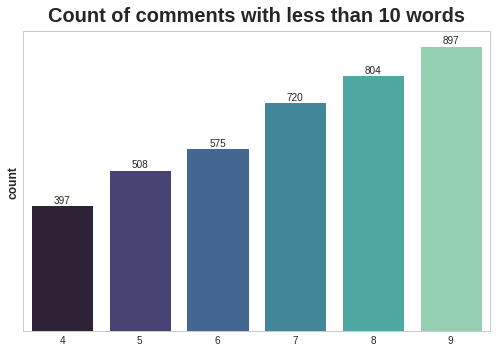

In [44]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of comments with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [45]:
df = df[df['text_len'] > 3]

In [46]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,You so black and white trying to live like a n...,329
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,@EurekAlertAAAS: Researchers push to import to...,287
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",283
33724,"... I don't feel guilty for killing him, I jus...",age,"... I don't feel guilty for killing him, I jus...",276
10922,don't make rape jokes!!! don't make gay jokes!...,gender,don't make rape jokes!!! don't make gay jokes!...,237
...,...,...,...,...
43504,Fuck that dumb nigger,ethnicity,Fuck that dumb nigger,4
10904,How great are feminazi,gender,How great are feminazi,4
6746,Dnt be a #cyberbully,not_cyberbullying,Dnt be a #cyberbully,4
7422,RT @salvodan: @freebsdgirl http://t.co/A2I2K4as1u,not_cyberbullying,RT @salvodan: @freebsdgirl http://t.co/A2I2K4as1u,4


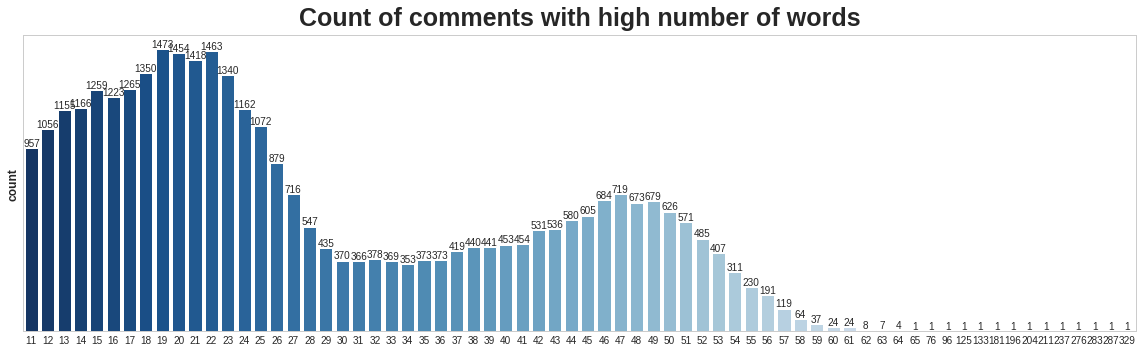

In [47]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of comments with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [48]:
df = df[df['text_len'] < 100]

In [49]:
max_len = np.max(df['text_len'])
max_len

96

In [50]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
21241,And yet God was able to meet their needs using...,religion,And yet God was able to meet their needs using...,96
42078,FUCK TRAYVON and FUCK YOU! The lil thug nigger...,ethnicity,FUCK TRAYVON and FUCK YOU! The lil thug nigger...,76
42651,Ayy Marco my dude I remember one of our first ...,ethnicity,Ayy Marco my dude I remember one of our first ...,65
37624,when ur friend makes a group chat for a game w...,age,when ur friend makes a group chat for a game w...,64
34482,a lot of girls message me &amp; ask me what i ...,age,a lot of girls message me &amp; ask me what i ...,64
...,...,...,...,...
3250,Just laugh about it.,not_cyberbullying,Just laugh about it.,4
3232,@BourgeoisBit Thank you Roooobbb!!!,not_cyberbullying,@BourgeoisBit Thank you Roooobbb!!!,4
3229,@ForeverPeazer hahaha that's me!!,not_cyberbullying,@ForeverPeazer hahaha that's me!!,4
3200,@Alana_fraiz me judge don't,not_cyberbullying,@Alana_fraiz me judge don't,4


In [51]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [54]:
X = df['text_clean']
y = df['sentiment']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [58]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5754],
       [   1, 5744],
       [   2, 5715],
       [   3, 5602],
       [   4, 5369]])

In [59]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [60]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [61]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5754],
       [   1, 5754],
       [   2, 5754],
       [   3, 5754],
       [   4, 5754]])

In [62]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [63]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [64]:
nb_clf = MultinomialNB()

In [65]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [66]:
nb_pred = nb_clf.predict(X_test_tf)

In [67]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.83      0.97      0.89      1599
         age       0.75      0.99      0.85      1595
   ethnicity       0.92      0.89      0.90      1588
      gender       0.89      0.87      0.88      1556
not bullying       0.89      0.46      0.60      1492

    accuracy                           0.84      7830
   macro avg       0.85      0.84      0.83      7830
weighted avg       0.85      0.84      0.83      7830



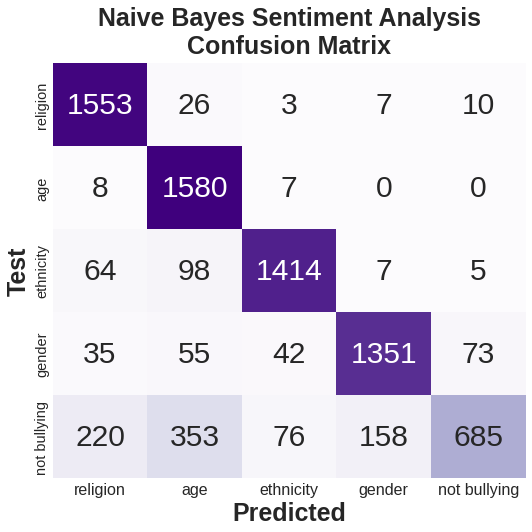

In [68]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

PyTorch Bi-LSTM RNN

In [69]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [70]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [71]:
df["text_clean"].iloc[10]

'The Bully flushes on KD http://twitvid.com/A2TNP'

In [72]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
          57,   773, 33276,    18, 33277, 33278])

In [73]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


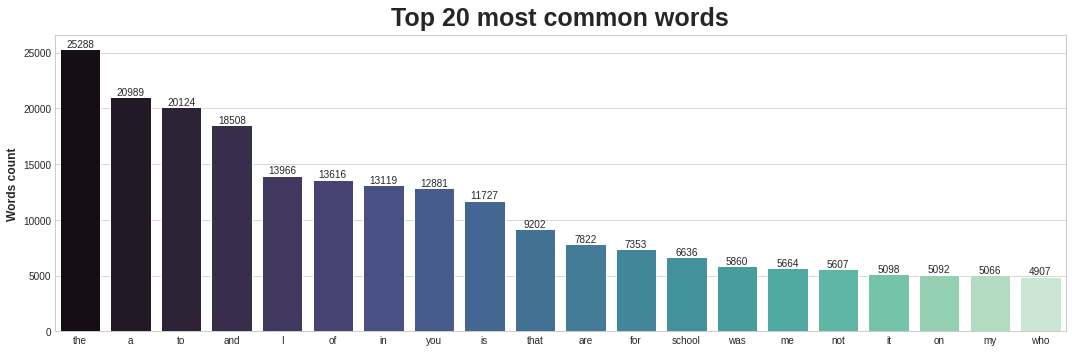

In [74]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [75]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [76]:
EMBEDDING_DIM = 200

In [78]:
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM)

In [79]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 107075


In [80]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [81]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (107075, 200)


In [82]:
X = tokenized_column
y = df['sentiment'].values

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [85]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5754],
       [   1, 5744],
       [   2, 5715],
       [   3, 5602],
       [   4, 5369]])

In [86]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [87]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5754],
       [   1, 5754],
       [   2, 5754],
       [   3, 5754],
       [   4, 5754]])

In [88]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [89]:
BATCH_SIZE = 32

In [90]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [91]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [92]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [93]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(107075, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [94]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [95]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 78.672680).  Saving model ...
	Train_loss : 1.0314 Val_loss : 0.5970
	Train_acc : 56.417% Val_acc : 78.673%
Epoch 2:Validation accuracy increased (78.672680 --> 89.690722).  Saving model ...
	Train_loss : 0.3287 Val_loss : 0.3022
	Train_acc : 89.075% Val_acc : 89.691%
Epoch 3:Validation accuracy increased (89.690722 --> 91.043814).  Saving model ...
	Train_loss : 0.1387 Val_loss : 0.2823
	Train_acc : 95.742% Val_acc : 91.044%
Epoch 4:Validation accuracy increased (91.043814 --> 91.688144).  Saving model ...
	Train_loss : 0.0588 Val_loss : 0.2730
	Train_acc : 98.370% Val_acc : 91.688%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0239 Val_loss : 0.2946
	Train_acc : 99.374% Val_acc : 91.591%


In [96]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [97]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [98]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.94      0.93      0.94      1592
         age       0.97      0.97      0.97      1590
   ethnicity       0.97      0.97      0.97      1584
      gender       0.88      0.87      0.88      1551
not bullying       0.81      0.84      0.83      1491

    accuracy                           0.92      7808
   macro avg       0.91      0.91      0.91      7808
weighted avg       0.92      0.92      0.92      7808



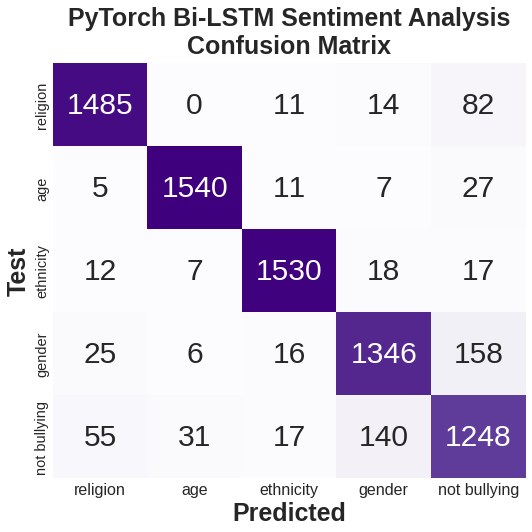

In [99]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

BERT Classification

In [100]:
X = df['text_clean'].values
y = df['sentiment'].values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [103]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [104]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [105]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5754],
       [   1, 5754],
       [   2, 5754],
       [   3, 5754],
       [   4, 5754]])

In [106]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [107]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [108]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  253


In [109]:
MAX_LEN = 128

In [110]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [111]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [112]:
batch_size = 32

In [113]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [114]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 97.5 µs


In [115]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [117]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

In [118]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [119]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.663645   |   63.20  
   200    |   0.266347   |   66.24  
   300    |   0.238591   |   66.09  
   400    |   0.222138   |   66.43  
   500    |   0.198435   |   66.64  
   600    |   0.175586   |   66.49  
   700    |   0.169722   |   66.41  
   800    |   0.158461   |   66.46  
   899    |   0.162864   |   65.30  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.251199    |  0.183542  |       94.22       |  615.52  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.119742   |   67.21  
   2

In [120]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [121]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [122]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.97      0.96      0.97      1599
         age       0.99      0.98      0.98      1595
   ethnicity       0.99      0.99      0.99      1588
      gender       0.93      0.94      0.93      1556
not bullying       0.89      0.88      0.89      1492

    accuracy                           0.95      7830
   macro avg       0.95      0.95      0.95      7830
weighted avg       0.95      0.95      0.95      7830



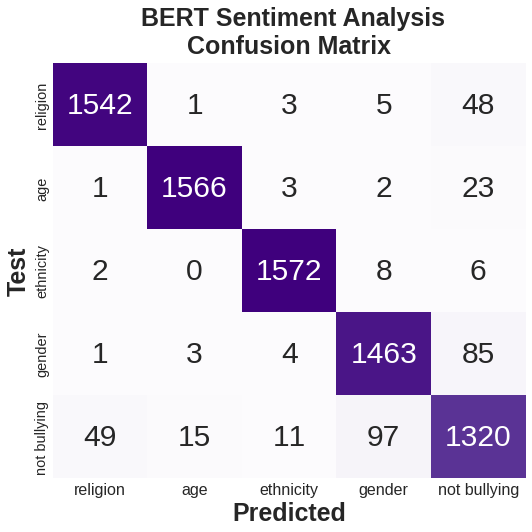

In [123]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)